# Import data and libraries

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from scipy.stats import dirichlet

hepatitis_names = ['Class', 'AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']
hepatitis = pd.read_table('Hepatitis/hepatitis.data', sep = ",", names=hepatitis_names)
hepatitis.reindex(index= ['Class', 'AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY'])
hepatitis

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,2,30,2,1,2,2,2,2,1,2,2,2,2,2,1.00,85,18,4.0,?,1
1,2,50,1,1,2,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,?,1
2,2,78,1,2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,?,1
3,2,31,1,?,1,2,2,2,2,2,2,2,2,2,0.70,46,52,4.0,80,1
4,2,34,1,2,2,2,2,2,2,2,2,2,2,2,1.00,?,200,4.0,?,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1,46,1,2,2,1,1,1,2,2,2,1,1,1,7.60,?,242,3.3,50,2
151,2,44,1,2,2,1,2,2,2,1,2,2,2,2,0.90,126,142,4.3,?,2
152,2,61,1,1,2,1,1,2,1,1,2,1,2,2,0.80,75,20,4.1,?,2
153,2,53,2,1,2,1,2,2,2,2,1,1,2,1,1.50,81,19,4.1,48,2


# 檢查是否有Categorical資料與缺失值

In [251]:
# find categorical variables

categorical = [var for var in hepatitis.columns if hepatitis[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

# view the categorical variables if they exist

hepatitis[categorical].head()

There are 15 categorical variables

The categorical variables are :

 ['STEROID', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']


,STEROID,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME
0,1,2,2,2,1,2,2,2,2,2,1.00,85,18,4.0,?
1,1,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,?
2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,?
3,?,2,2,2,2,2,2,2,2,2,0.70,46,52,4.0,80
4,2,2,2,2,2,2,2,2,2,2,1.00,?,200,4.0,?


In [252]:
# 刪除有缺失值的資料，在這個資料集中，缺失值是用'?'來表示的
hepatitis = hepatitis[(hepatitis != '?').all(axis=1)]

In [253]:
# 計算各個 class 的個數
freq = hepatitis['Class'].value_counts()
print(freq)

2    67
1    13
Name: Class, dtype: int64


In [254]:
hepatitis.shape[0]

80

# Data Preprocessing

## Ten-bin discretization

In [255]:
X = hepatitis[['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']]
y = hepatitis['Class']

# 對 class 和 連續型的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

In [256]:
print(X_t[0])

[2. 0. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 1. 2. 0. 6. 7. 0.]


In [257]:
print(np.shape(X_t))

(80, 19)


#  Model 1 : Naive Bayesian classifier have Dirichlet priors with the Laplace’s estimate

In [258]:
import scipy.stats
# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [13, 67], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

[[0.23866586 0.76133414]]


MultinomialNB(alpha=1, class_prior=array([0.23866586, 0.76133414]))

## 5-Fold cross validation

In [259]:
score = cross_val_score(clf, X_t, y, scoring='f1', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

Means of 5-Fold cross validation: 0.597


## Ranking Attribute by selective naïve Bayes

In [260]:
result = permutation_importance(clf, X_t, y,scoring='f1', random_state=0)

print(result.importances_mean)

[ 0.00806452  0.10748053  0.00690371 -0.02567204 -0.0047043  -0.00924976
  0.01612903 -0.00430108  0.          0.00403226 -0.00078201 -0.00835777
  0.         -0.021802    0.00806452  0.         -0.02137097  0.00403226
  0.11470237]


In [261]:
importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])

0.11470236840255812
0.10748053392658505
0.016129032258064502
0.008064516129032251
0.008064516129032251
0.0069037145650048485
0.0040322580645161255
0.0040322580645161255
0.0       
0.0       
0.0       
-0.0007820136852395354
-0.0043010752688172225
-0.004704301075268846
-0.008357771260997104
-0.00924975562072341
-0.021370967741935497
-0.021802002224694174
-0.025672043010752765


<function matplotlib.pyplot.show(close=None, block=None)>

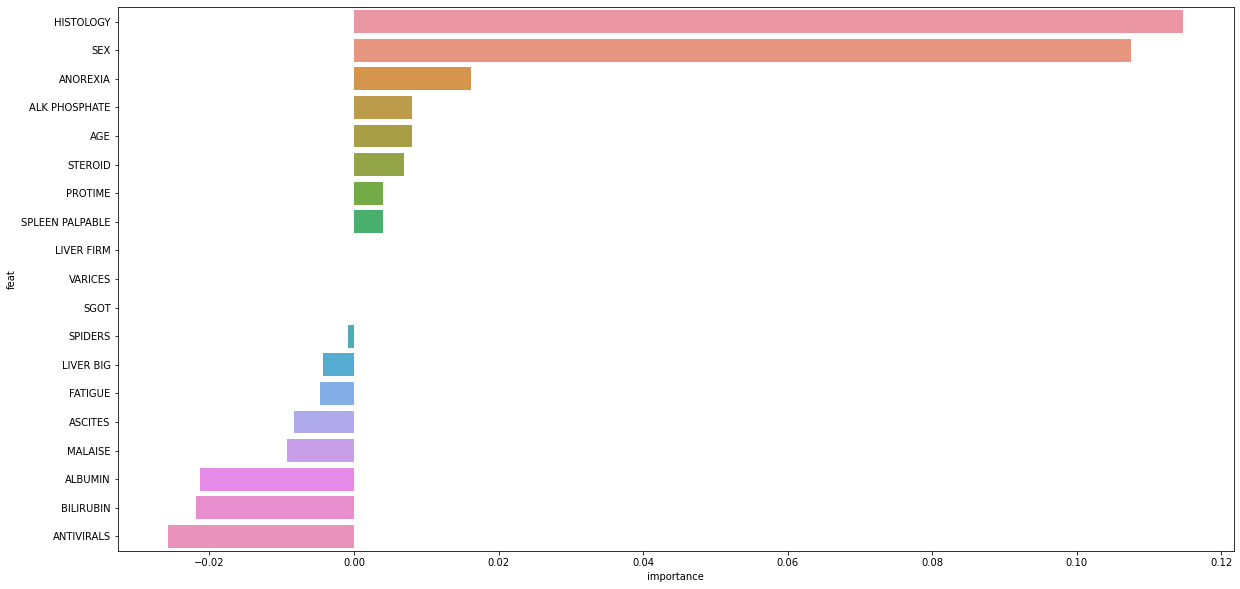

In [262]:
# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

## 重新排序特徵

In [263]:
# 刪除重要性是負數的特徵
X = hepatitis[['AGE', 'SEX', 'STEROID',  'ANOREXIA',
               'LIVER FIRM', 'SPLEEN PALPABLE', 'VARICES', 'ALK PHOSPHATE',
               'SGOT', 'PROTIME', 'HISTOLOGY']]
y = hepatitis['Class']

print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# Model
import scipy.stats
# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [13, 67], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='f1', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

result = permutation_importance(clf, X_t, y,scoring='f1', random_state=0)

print(result.importances_mean)

importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])


    AGE  SEX STEROID ANOREXIA LIVER FIRM SPLEEN PALPABLE VARICES  \
5    34    1       2        2          2               2       2   
10   39    1       1        2          1               2       2   
11   32    1       2        2          1               2       2   
12   41    1       2        2          1               2       2   
13   30    1       2        2          1               2       2   

   ALK PHOSPHATE SGOT PROTIME  HISTOLOGY  
5             95   28      75          1  
10            78   30      85          1  
11            59  249      54          1  
12            81   60      52          1  
13            57  144      78          1  
[[0.23866586 0.76133414]]
Means of 5-Fold cross validation: 0.64
[ 0.00836237  0.04687988 -0.03049274 -0.00585366  0.00557491  0.
  0.00278746  0.00544526  0.          0.01646544  0.24601924]
0.24601923592182592
0.04687987780413966
0.01646544040191227
0.008362369337979025
0.005574912891986017
0.0054452637549631255
0.002787456445993

# 額外實驗：將accuracy替換為F1 score, Precision 和 recall

## Precision

In [264]:
scoring = 'precision'

In [265]:
X = hepatitis[['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']]
y = hepatitis['Class']

# 對 class 和 連續型的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [13, 67], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.23866586 0.76133414]]
Means of 5-Fold cross validation: 0.59


[ 0.01169591  0.09437135  0.02450292 -0.00023392  0.0004816   0.00865497
  0.02339181 -0.00653595  0.          0.00584795  0.01333333  0.00280702
  0.         -0.03349673  0.01169591  0.         -0.00818713  0.00584795
  0.10150376]
0.10150375939849629
0.0943713450292398
0.024502923976608203
0.02339181286549712
0.01333333333333333
0.01169590643274856
0.01169590643274856
0.008654970760233915
0.00584795321637428
0.00584795321637428
0.00280701754385968
0.00048159614723084496
0.0       
0.0       
0.0       
-0.0002339181286549863
-0.0065359477124183
-0.008187134502923965
-0.03349673202614378


<function matplotlib.pyplot.show(close=None, block=None)>

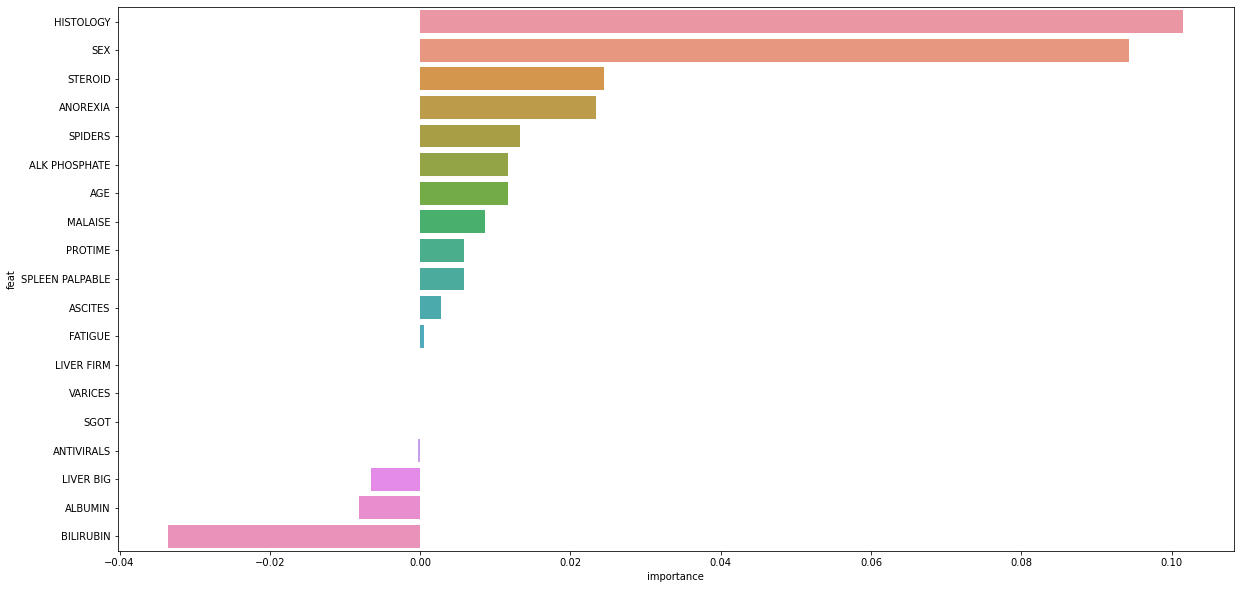

In [266]:
result = permutation_importance(clf, X_t, y,scoring=scoring, random_state=0)

print(result.importances_mean)

importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])

# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

### Precision : 刪掉負的特徵之後

In [267]:
# 刪除重要性是負數的特徵
X = hepatitis[['AGE', 'SEX', 'STEROID', 'FATIGUE', 'MALAISE', 'ANOREXIA',\
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES','ALK PHOSPHATE', \
               'SGOT','PROTIME', 'HISTOLOGY']]
y = hepatitis['Class']

print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# Model
import scipy.stats
# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [13, 67], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='precision', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

    AGE  SEX STEROID FATIGUE MALAISE ANOREXIA LIVER FIRM SPLEEN PALPABLE  \
5    34    1       2       2       2        2          2               2   
10   39    1       1       2       2        2          1               2   
11   32    1       2       1       2        2          1               2   
12   41    1       2       1       2        2          1               2   
13   30    1       2       1       2        2          1               2   

   SPIDERS ASCITES VARICES ALK PHOSPHATE SGOT PROTIME  HISTOLOGY  
5        2       2       2            95   28      75          1  
10       2       2       2            78   30      85          1  
11       1       2       2            59  249      54          1  
12       2       2       2            81   60      52          1  
13       2       2       2            57  144      78          1  
[[0.23866586 0.76133414]]
Means of 5-Fold cross validation: 0.613


## F1 Score

In [268]:
scoring = 'f1'

In [269]:
X = hepatitis[['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']]
y = hepatitis['Class']

# 對 class 和 連續型的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [13, 67], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.23866586 0.76133414]]
Means of 5-Fold cross validation: 0.597


[ 0.00806452  0.10748053  0.00690371 -0.02567204 -0.0047043  -0.00924976
  0.01612903 -0.00430108  0.          0.00403226 -0.00078201 -0.00835777
  0.         -0.021802    0.00806452  0.         -0.02137097  0.00403226
  0.11470237]
0.11470236840255812
0.10748053392658505
0.016129032258064502
0.008064516129032251
0.008064516129032251
0.0069037145650048485
0.0040322580645161255
0.0040322580645161255
0.0       
0.0       
0.0       
-0.0007820136852395354
-0.0043010752688172225
-0.004704301075268846
-0.008357771260997104
-0.00924975562072341
-0.021370967741935497
-0.021802002224694174
-0.025672043010752765


<function matplotlib.pyplot.show(close=None, block=None)>

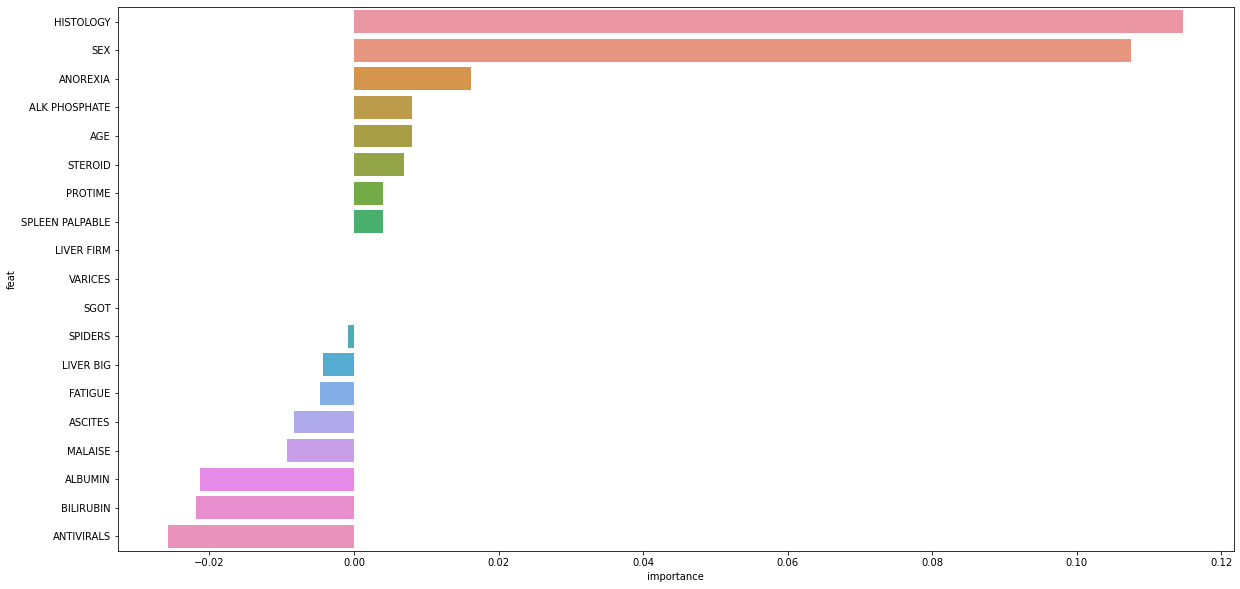

In [270]:
result = permutation_importance(clf, X_t, y,scoring=scoring, random_state=0)

print(result.importances_mean)

importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])

# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

### F1 Score：刪掉負的特徵之後

In [271]:
# 刪除重要性是負數的特徵
X = hepatitis[['AGE', 'SEX', 'STEROID', 'ANOREXIA', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'VARICES','ALK PHOSPHATE', \
               'SGOT','PROTIME', 'HISTOLOGY']]
y = hepatitis['Class']

print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# Model
import scipy.stats
# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [13, 67], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

    AGE  SEX STEROID ANOREXIA LIVER FIRM SPLEEN PALPABLE VARICES  \
5    34    1       2        2          2               2       2   
10   39    1       1        2          1               2       2   
11   32    1       2        2          1               2       2   
12   41    1       2        2          1               2       2   
13   30    1       2        2          1               2       2   

   ALK PHOSPHATE SGOT PROTIME  HISTOLOGY  
5             95   28      75          1  
10            78   30      85          1  
11            59  249      54          1  
12            81   60      52          1  
13            57  144      78          1  
[[0.23866586 0.76133414]]
Means of 5-Fold cross validation: 0.64


## Recall

In [272]:
scoring = 'recall'

In [273]:
X = hepatitis[['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']]
y = hepatitis['Class']

# 對 class 和 連續型的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [13, 67], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.23866586 0.76133414]]
Means of 5-Fold cross validation: 0.733


[ 0.          0.12307692 -0.03076923 -0.07692308 -0.01538462 -0.04615385
  0.          0.          0.          0.         -0.03076923 -0.03076923
  0.          0.          0.          0.         -0.04615385  0.
  0.12307692]
0.12307692307692313
0.12307692307692311
0.0       
0.0       
0.0       
0.0       
0.0       
0.0       
0.0       
0.0       
0.0       
0.0       
-0.015384615384615375
-0.03076923076923075
-0.03076923076923075
-0.03076923076923077
-0.04615384615384612
-0.04615384615384612
-0.07692307692307687


<function matplotlib.pyplot.show(close=None, block=None)>

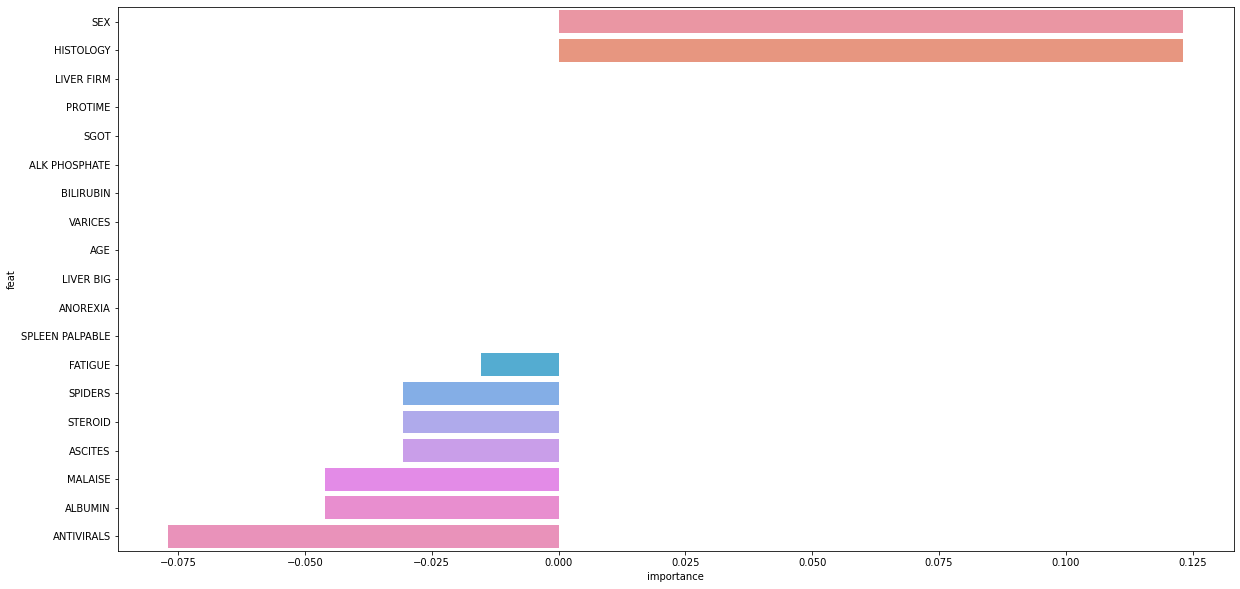

In [274]:
result = permutation_importance(clf, X_t, y,scoring=scoring, random_state=0)

print(result.importances_mean)

importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])

# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

### Recall：刪掉負的特徵之後

In [275]:
# 刪除重要性是負數的特徵
X = hepatitis[['SEX','HISTOLOGY']]
y = hepatitis['Class']

print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# Model
import scipy.stats
# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [13, 67], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

    SEX  HISTOLOGY
5     1          1
10    1          1
11    1          1
12    1          1
13    1          1
[[0.23866586 0.76133414]]
Means of 5-Fold cross validation: 0.9


#  Model 2 : Naive Bayesian classifier have  the best noninformative Dirichlet priors

In [276]:
# 可將scoring其依序替換為'accuracy', 'precision', 'recall'來得到其表現結果
# 然後再手動將負的特徵刪掉就可以得到實驗結果
scoring = 'f1'

In [277]:
X = hepatitis[['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']]
y = hepatitis['Class']

# 對 class 和 連續型的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [1, 1], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.29751149 0.70248851]]
Means of 5-Fold cross validation: 0.59


[-0.00040323  0.09736559  0.00690371 -0.02567204 -0.0047043   0.00679231
  0.01612903 -0.00430108  0.          0.00403226 -0.00078201 -0.00835777
  0.         -0.02610308  0.00338393  0.         -0.00900538 -0.00040323
  0.11470237]
0.11470236840255812
0.09736559139784944
0.016129032258064502
0.0069037145650048485
0.006792306365361345
0.0040322580645161255
0.003383934218848794
0.0       
0.0       
0.0       
-0.00040322580645162364
-0.00040322580645162364
-0.0007820136852395354
-0.0043010752688172225
-0.004704301075268846
-0.008357771260997104
-0.00900537634408607
-0.025672043010752765
-0.026103077493511352


<function matplotlib.pyplot.show(close=None, block=None)>

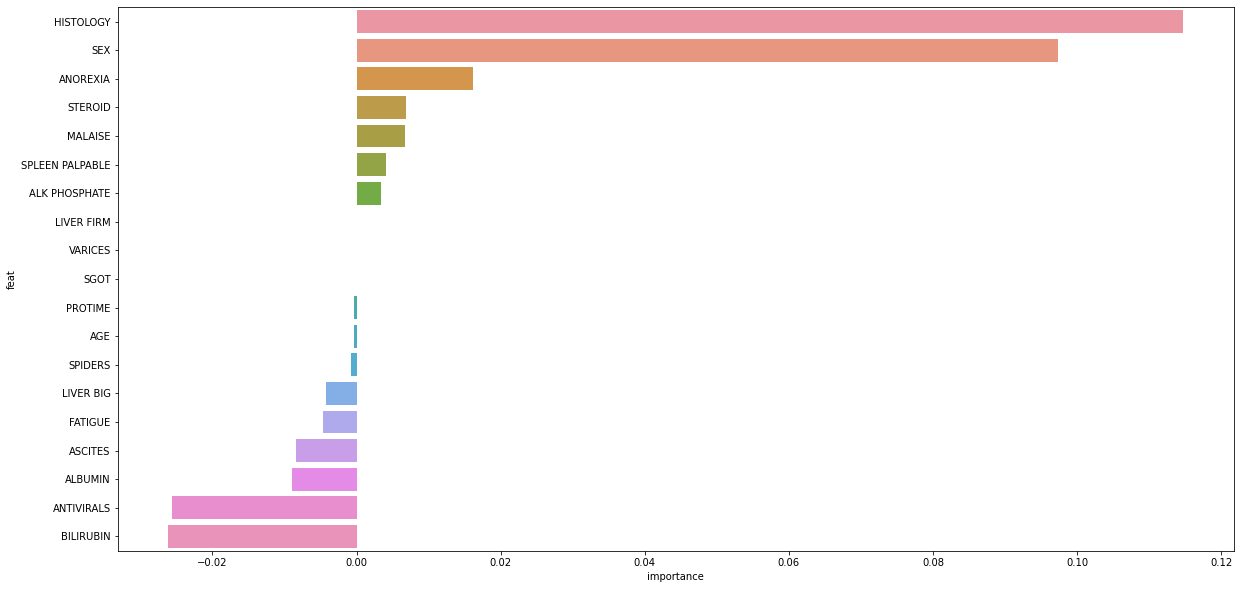

In [278]:
result = permutation_importance(clf, X_t, y,scoring=scoring, random_state=0)

print(result.importances_mean)

importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])

# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', \
               'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

In [279]:
# 刪除重要性是負數的特徵
X = hepatitis[['SEX', 'STEROID', 'MALAISE', 'ANOREXIA', \
               'LIVER FIRM', 'SPLEEN PALPABLE', 'VARICES', 'ALK PHOSPHATE', \
               'SGOT', 'HISTOLOGY']]
y = hepatitis['Class']

print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# Model
import scipy.stats
# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [13, 67], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

    SEX STEROID MALAISE ANOREXIA LIVER FIRM SPLEEN PALPABLE VARICES  \
5     1       2       2        2          2               2       2   
10    1       1       2        2          1               2       2   
11    1       2       2        2          1               2       2   
12    1       2       2        2          1               2       2   
13    1       2       2        2          1               2       2   

   ALK PHOSPHATE SGOT  HISTOLOGY  
5             95   28          1  
10            78   30          1  
11            59  249          1  
12            81   60          1  
13            57  144          1  
[[0.23866586 0.76133414]]
Means of 5-Fold cross validation: 0.613
